In [1]:
from pathlib import Path
import json
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load human eval annotations

In [15]:
# store human eval annotations in these data structures:
# {model: {annotator: {topic: {score: [sample1, ...] } } } }
num_samples = 10
annotations = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(
                lambda: [None for _ in range(num_samples)]
            )
        )
    )
) 
# {model: {topic: [sample1, ...] } } 
intruders = defaultdict(
    lambda: defaultdict(
        lambda: [None for _ in range(num_samples)]
    )
)

for annotated_samples_f in Path("cluster_eval").glob("*/*.json"):
    a = annotated_samples_f.parent.name # annotator id
    m = annotated_samples_f.name.split("_")[0] # model id
    try:
        json_dict = json.loads(annotated_samples_f.read_text())
    except json.JSONDecodeError as e:
        print(f"Failed to read json for annotator {a}, model {m}")
        raise e
    for topic_sample, sample in json_dict.items():
        t, s = topic_sample.replace("topic_", "").replace("sample_", "").split("_")
        s = int(s)
        if a == "intruders_ground_truth":
            intruders[m][t][s] = str(sample)
        else:
            if 'interpretability' in sample:
                sample['coherence'] = sample['interpretability']
            if sample['coherence'] == '':
                print(m)
                print(a)
                print(t)
                print(s)
            annotations[m][a][t]["coherence"][s] = sample["coherence"]
            annotations[m][a][t]["usefulness"][s] = sample["usefulness"]
            annotations[m][a][t]["intruder"][s] = sample["intruder"]
            annotations[m][a][t]["samples"][s] = sample["text"]

## Normalize annotation scores

In [17]:
for m in annotations.keys():
    for a in annotations[m].keys():
        for t in annotations[m][a].keys():
            # calculate % correct/unknown/incorrect intruders identified
            correct_intruders = 0
            unknown_intruders = 0
            incorrect_intruders = 0
            pred_intruders = annotations[m][a][t]['intruder']
            gold_intruders = intruders[m][t]
            for gold, pred in zip(gold_intruders, pred_intruders):
                if gold == pred:
                    correct_intruders += 1
                elif pred == '5':
                    unknown_intruders += 1
                else:
                    incorrect_intruders += 1
            annotations[m][a][t]["correct_intruder"] = correct_intruders / num_samples
            annotations[m][a][t]["unknown_intruder"] = unknown_intruders / num_samples
            annotations[m][a][t]["incorrect_intruder"] = incorrect_intruders / num_samples
            
            # calculate % coherent/ambiguous/incoherent
            coherent = 0
            incoherent = 0
            ambiguous = 0
            useful = 0
            useless = 0
            avg_coherence = 0
            std_coherence = []
            for c in annotations[m][a][t]['coherence']:
                if c == '1':
                    coherent += 1
                elif c == '2':
                    ambiguous += 1
                else:
                    incoherent += 1
                avg_coherence += (3 - int(c))/2
                std_coherence += [(3 - int(c))/2]
            for u in annotations[m][a][t]['usefulness']:
                if u == '1':
                    useful += 1
                else:
                    useless += 1
            annotations[m][a][t]["coherent"] = coherent / num_samples
            annotations[m][a][t]["incoherent"] = incoherent / num_samples
            annotations[m][a][t]["ambiguous"] = ambiguous / num_samples
            annotations[m][a][t]["avg_coherence"] = avg_coherence / num_samples
            annotations[m][a][t]["std_coherence"] = np.std(std_coherence)
            annotations[m][a][t]["useful"] = useful / num_samples
            annotations[m][a][t]["useless"] = useless / num_samples
            

            
{k:v for k,v in annotations[m]['0'][t].items() if k != 'samples'}

{'coherence': ['3', '3', '3', '2', '3', '3', '3', '3', '3', '3'],
 'usefulness': ['3', '3', '3', '2', '3', '3', '3', '3', '3', '3'],
 'intruder': ['5', '5', '5', '4', '5', '5', '5', '5', '5', '5'],
 'correct_intruder': 0.0,
 'unknown_intruder': 0.9,
 'incorrect_intruder': 0.1,
 'coherent': 0.0,
 'incoherent': 0.9,
 'ambiguous': 0.1,
 'avg_coherence': 0.05,
 'std_coherence': 0.15000000000000002,
 'useful': 0.0,
 'useless': 1.0}

## Average scores across annotators

In [18]:
# Compute average of normalized/categorized scores  
# (across annotators for a given model and topic)
# and store in this data structure:
# {model: {score: {topic: ...} } } 
avg_scores = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(list)
    )
)

score_keys = [s for s in annotations[m][a][t] if s not in ['coherence', 'usefulness', 'intruder']]
for m in annotations.keys():
    for s in score_keys:
        if s == "samples":
            continue
        for a in annotations[m].keys():
            for t in annotations[m][a].keys():
                avg_scores[m][s][t] += [annotations[m][a][t][s]]
                
        for t in annotations[m][a].keys():
                avg_scores[m][s][t] = np.mean(avg_scores[m][s][t])

In [21]:
scores_to_label = {s:s.replace("_", " ").title() for s in score_keys}
scores_to_label

{'samples': 'Samples',
 'correct_intruder': 'Correct Intruder',
 'unknown_intruder': 'Unknown Intruder',
 'incorrect_intruder': 'Incorrect Intruder',
 'coherent': 'Coherent',
 'incoherent': 'Incoherent',
 'ambiguous': 'Ambiguous',
 'avg_coherence': 'Avg Coherence',
 'std_coherence': 'Std Coherence',
 'useful': 'Useful',
 'useless': 'Useless'}

## Plot scores for each topic/model

In [26]:
def plot_model_topic_scores(score: str, models):
    rows = []
    index = []
    for m in models.keys():
        index.append(models[m])
        row = avg_scores[m][score]
        rows.append(row)
    df = pd.DataFrame(rows, index=index)
    
    plt.rcParams['figure.figsize'] = [8, 2]
    plt.pcolor(df, cmap='Blues', vmin=0, vmax=1)
    cbar = plt.colorbar(ticks = [0,0.5,1.0])
    cbar.ax.tick_params(labelsize=12)
    cbar.set_ticklabels([0,0.5,1.0])
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index, fontsize=15)
    plt.xticks([], [], fontsize=15)
    plt.xlabel("Topic", fontsize=15)
    plt.show()
    print("Average")
    for i,r in df.iterrows():
        print(f"{i}: {r.mean()}")
    print("Num >0.5")
    for i,r in df.iterrows():
        print(f"{i}: {len(r[r>0.5])}")
    
    return df

In [27]:
models = {
    '5': "LDA",
    '4': "BERT",
    '1': "BTM", 
#     '2': "cls",  
#     '3': "clstr", 
    '0': "FTE",
}

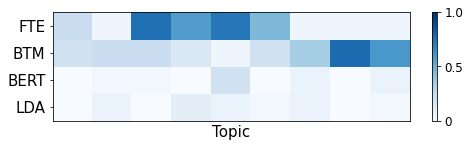

Average
LDA: 0.040740740740740744
BERT: 0.044444444444444446
BTM: 0.30833333333333335
FTE: 0.32499999999999996
Num >0.5
LDA: 0
BERT: 0
BTM: 2
FTE: 3


,0,1,2,3,4,5,6,7,8
LDA,0.000,0.066667,0.000000,0.100,0.066667,0.033333,0.066667,0.000,0.033333
BERT,0.000,0.033333,0.033333,0.000,0.200000,0.000000,0.066667,0.000,0.066667
BTM,0.200,0.225000,0.225000,0.150,0.050000,0.200000,0.350000,0.775,0.600000
FTE,0.225,0.050000,0.750000,0.575,0.725000,0.450000,0.050000,0.050,0.050000


In [28]:
plot_model_topic_scores("coherent", models)

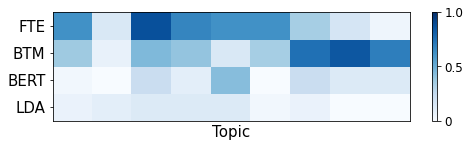

Average
LDA: 0.07407407407407408
BERT: 0.14444444444444446
BTM: 0.4555555555555556
FTE: 0.461111111111111
Num >0.5
LDA: 0
BERT: 0
BTM: 3
FTE: 5


,0,1,2,3,4,5,6,7,8
LDA,0.066667,0.100,0.133333,0.133333,0.133333,0.033333,0.066667,0.000000,0.000000
BERT,0.033333,0.000,0.233333,0.100000,0.433333,0.000000,0.233333,0.133333,0.133333
BTM,0.375000,0.075,0.450000,0.400000,0.150000,0.350000,0.750000,0.850000,0.700000
FTE,0.625000,0.150,0.875000,0.675000,0.625000,0.625000,0.350000,0.175000,0.050000


In [29]:
plot_model_topic_scores("useful", models)

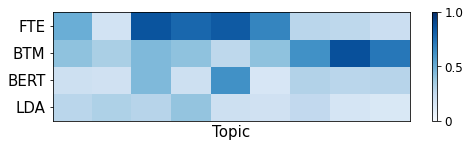

Average
LDA: 0.2569444444444444
BERT: 0.30694444444444446
BTM: 0.5027777777777778
FTE: 0.5152777777777777
Num >0.5
LDA: 0
BERT: 1
BTM: 3
FTE: 4


,0,1,2,3,4,5,6,7,8
LDA,0.2875,0.3250,0.3000,0.4000,0.2125,0.2000,0.2625,0.1750,0.150
BERT,0.2125,0.2000,0.4500,0.2125,0.6250,0.1625,0.3125,0.2875,0.300
BTM,0.4125,0.3375,0.4500,0.4125,0.2750,0.4125,0.6250,0.8750,0.725
FTE,0.5000,0.1875,0.8625,0.7875,0.8375,0.6750,0.2875,0.2750,0.225


In [11]:
plot_model_topic_scores("avg_coherence")

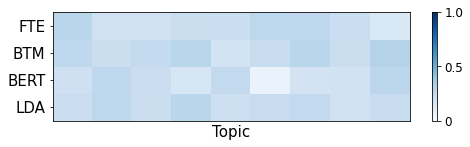

Average
LDA: 0.24229388903591376
BERT: 0.20605885314414035
BTM: 0.25538528337553523
FTE: 0.22965683450842253
Num >0.5
LDA: 0
BERT: 0
BTM: 0
FTE: 0


,0,1,2,3,4,5,6,7,8
LDA,0.224693,0.278487,0.229966,0.292399,0.213504,0.242204,0.259710,0.202753,0.236930
BERT,0.209710,0.270264,0.223385,0.166667,0.258055,0.066667,0.185090,0.193043,0.281650
BTM,0.270090,0.229835,0.255390,0.287097,0.188817,0.239872,0.291607,0.227698,0.308062
FTE,0.287730,0.200230,0.201435,0.227064,0.224987,0.281019,0.270606,0.223839,0.150000


In [30]:
plot_model_topic_scores("std_coherence", models)

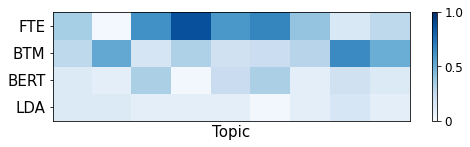

Average
LDA: 0.10740740740740741
BERT: 0.17777777777777778
BTM: 0.3527777777777778
FTE: 0.44166666666666665
Num >0.5
LDA: 0
BERT: 0
BTM: 2
FTE: 4


,0,1,2,3,4,5,6,7,8
LDA,0.133333,0.133333,0.100000,0.100000,0.100000,0.033333,0.1,0.166667,0.100000
BERT,0.133333,0.100000,0.333333,0.033333,0.233333,0.333333,0.1,0.200000,0.133333
BTM,0.275000,0.525000,0.175000,0.325000,0.200000,0.225000,0.3,0.650000,0.500000
FTE,0.350000,0.025000,0.625000,0.875000,0.600000,0.675000,0.4,0.150000,0.275000


In [31]:
plot_model_topic_scores("correct_intruder", models)

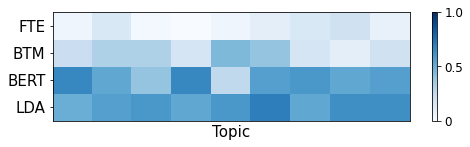

Average
LDA: 0.588888888888889
BERT: 0.5333333333333333
BTM: 0.2638888888888889
FTE: 0.08888888888888888
Num >0.5
LDA: 8
BERT: 7
BTM: 0
FTE: 0


,0,1,2,3,4,5,6,7,8
LDA,0.500000,0.566667,0.600,0.533333,0.600000,0.700000,0.533333,0.633333,0.633333
BERT,0.666667,0.533333,0.400,0.666667,0.266667,0.566667,0.600000,0.533333,0.566667
BTM,0.225000,0.325000,0.325,0.175000,0.450000,0.400000,0.175000,0.100000,0.200000
FTE,0.050000,0.150000,0.025,0.000000,0.050000,0.100000,0.150000,0.200000,0.075000


In [32]:
plot_model_topic_scores("unknown_intruder", models)

## Inter rater agreement (Fleiss Kappa)

In [33]:
annotators = list(annotations[m].keys())
topics = list(sorted(annotations[m][a].keys(), key=lambda x: int(x)))
scores_per_topic = len(sum([annotations[m][a][t]["coherence"] for t in topics], []))

fleiss = {
    "u": {m: pd.DataFrame() for m in annotations.keys()}, # useful
    "c": {m: pd.DataFrame() for m in annotations.keys()}, # coherent
    "i": {m: pd.DataFrame() for m in annotations.keys()}, # intruder
    "u_pi": {},
    "c_pi": {},
    "i_pi": {},
    "u_P": {},
    "c_P": {},
    "i_P": {},
    "u_Pe": {},
    "c_Pe": {},
    "i_Pe": {},
    "k": {}
}


for m,model in models.items():
    fleiss["u"][m]["1"] = [0 for _ in range(scores_per_topic)]
    fleiss["u"][m]["2"] = [0 for _ in range(scores_per_topic)]
    fleiss["c"][m]["1"] = [0 for _ in range(scores_per_topic)]
    fleiss["c"][m]["2"] = [0 for _ in range(scores_per_topic)]
    fleiss["c"][m]["3"] = [0 for _ in range(scores_per_topic)]
    fleiss["i"][m]["1"] = [0 for _ in range(scores_per_topic)]
    fleiss["i"][m]["2"] = [0 for _ in range(scores_per_topic)]
    fleiss["i"][m]["3"] = [0 for _ in range(scores_per_topic)]
    fleiss["i"][m]["4"] = [0 for _ in range(scores_per_topic)]
    fleiss["i"][m]["5"] = [0 for _ in range(scores_per_topic)]
    fleiss["i"][m]["0"] = [0 for _ in range(scores_per_topic)]
    
    for a in annotators:
        fleiss["u"][m]["1"] += [1 if s=="1" else 0 for t in topics for s in annotations[m][a][t]["usefulness"]]
        fleiss["u"][m]["2"] += [1 if s=="2" else 0 for t in topics for s in annotations[m][a][t]["usefulness"]]
        fleiss["c"][m]["1"] += [1 if s=="1" else 0 for t in topics for s in annotations[m][a][t]["coherence"]]
        fleiss["c"][m]["2"] += [1 if s=="2" else 0 for t in topics for s in annotations[m][a][t]["coherence"]]
        fleiss["c"][m]["3"] += [1 if s=="3" else 0 for t in topics for s in annotations[m][a][t]["coherence"]]
        fleiss["i"][m]["0"] += [1 if s=="0" else 0 for t in topics for s in annotations[m][a][t]["intruder"]]
        fleiss["i"][m]["1"] += [1 if s=="1" else 0 for t in topics for s in annotations[m][a][t]["intruder"]]
        fleiss["i"][m]["2"] += [1 if s=="2" else 0 for t in topics for s in annotations[m][a][t]["intruder"]]
        fleiss["i"][m]["3"] += [1 if s=="3" else 0 for t in topics for s in annotations[m][a][t]["intruder"]]
        fleiss["i"][m]["4"] += [1 if s=="4" else 0 for t in topics for s in annotations[m][a][t]["intruder"]]
        fleiss["i"][m]["5"] += [1 if s=="5" else 0 for t in topics for s in annotations[m][a][t]["intruder"]]
        

    n = 4 # number of raters  

    N = len(fleiss["c"][m]) # number of subjects

    fleiss["i_pi"][m] = [x/fleiss["i"][m].sum().sum() for x in fleiss["i"][m].sum()]
    fleiss["c_pi"][m] = [x/fleiss["c"][m].sum().sum() for x in fleiss["c"][m].sum()]
    fleiss["u_pi"][m] = [x/fleiss["u"][m].sum().sum() for x in fleiss["u"][m].sum()]

    
    fleiss["i"][m]["P_i"] = (1/(n*(n-1))) * (sum([fleiss["i"][m][c] ** 2 for c in fleiss["i"][m].columns]) - n)
    fleiss["c"][m]["P_i"] = (1/(n*(n-1))) * (sum([fleiss["c"][m][c] ** 2 for c in fleiss["c"][m].columns]) - n)
    fleiss["u"][m]["P_i"] = (1/(n*(n-1))) * (sum([fleiss["u"][m][c] ** 2 for c in fleiss["u"][m].columns]) - n)

    fleiss["i_P"][m] = fleiss["i"][m]["P_i"].mean()
    fleiss["c_P"][m] = fleiss["c"][m]["P_i"].mean()
    fleiss["u_P"][m] = fleiss["u"][m]["P_i"].mean()


    fleiss["i_Pe"][m] = sum([x**2 for x in fleiss["i_pi"][m]])
    fleiss["c_Pe"][m] = sum([x**2 for x in fleiss["c_pi"][m]])
    fleiss["u_Pe"][m] = sum([x**2 for x in fleiss["u_pi"][m]])
    
    fleiss["k"][m] = {}
    fleiss["k"][m]["i"] = (fleiss["i_P"][m] - fleiss["i_Pe"][m]) / (1 - fleiss["i_Pe"][m])
    fleiss["k"][m]["c"] = (fleiss["c_P"][m] - fleiss["c_Pe"][m]) / (1 - fleiss["c_Pe"][m])
    fleiss["k"][m]["u"] = (fleiss["u_P"][m] - fleiss["u_Pe"][m]) / (1 - fleiss["u_Pe"][m])

    print(model)
    print(fleiss["k"][m])

LDA
{'i': -0.3814565429254897, 'c': -0.640557507343201, 'u': -4.188664366053172}
BERT
{'i': -0.33537706928264877, 'c': -0.5882763613797382, 'u': -2.1467140758547014}
BTM
{'i': -0.10597873453024231, 'c': -0.3361601933655609, 'u': -0.6577668615194657}
FTE
{'i': -0.03714912864174539, 'c': -0.2916371367824238, 'u': -0.6628605112657473}


## Latex tweet samples

In [34]:
s = ""
special_chars = ["{", "}", "&", "_", "#", "%", "$"]
for m in ['0', '1']:
    s += f"\\subsection{{Model: {m}}}\n"
    for t in sorted(annotations[m][a].keys(), key=lambda x: int(x)):
        s += f"\\subsubsection{{Topic {t}}}\n"
        s += "\\begin{itemize}\n"
        for i,sample in enumerate(annotations[m][a][t]["samples"][0]):
            s += "\t \\item "
            if i == int(intruders[m][t][0]):
                s += "INTRUDER: "
            for sc in special_chars:
                sample = sample.replace(sc, f"\\{sc}")
            sample = sample.replace("\n", " ").replace("\t", " ").encode('ascii', errors="ignore").decode()
            s += f"{sample} \n"
            
        s += "\\end{itemize}\n"
print(s)

\subsection{Model: 0}
\subsubsection{Topic 0}
\begin{itemize}
	 \item How bad was the blizzard in St. John's,  Newfoundland? Here's what a seniors home looks like the day after.  photo: https://t.co/6n8txqnuWl 
	 \item East End of St. Johns 4 days post blizzard. \#NLwx \#NLtraffic        \#snowmegeddon2020 https://t.co/5s2p9Ivejf 
	 \item Well here's the big mother storm en route. Currently the size of Nova Scotia, nbd. \#nlwx https://t.co/CFi9szzunK 
	 \item INTRUDER: I hope I don't have to go to work on  Monday because I don't remember my password anymore. \#nlwx \#stormageddon2020 https://t.co/BswQppEFVh 
	 \item \#StJohns declares \#StateOfEmergency and \#Newfoundland and \#Labrador get pounded with \#SnowFall with more to come  https://t.co/JNxnIF5mNx 
\end{itemize}
\subsubsection{Topic 1}
\begin{itemize}
	 \item Gentle heart of Jesus \#nlwx https://t.co/cEbvv3it5f 
	 \item This was the moment I fell in love with \#Newfoundland, \#Canada when I first entered the Gros Morne Nationa